**1. Colab 환경설정**

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install konlpy
!pip install torch
!pip install ipywidgets  # for vscode
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49.1 MB 1.3 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 344 kB 4.1 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595746 sha256=b0452d26e21a98293e2d7a7bbe09e6e60bb983a354c7296abf6018a2a8d035e0
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.2 MB 4.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg

In [2]:
import torch
#gpu 사용시에만 적용
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#GPU 사용
device = torch.device("cuda:0")

Sat Jun 18 22:36:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#RAM 셋팅
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [4]:
import pandas as pd
import konlpy
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm.notebook import tqdm

Mounted at /content/drive


In [5]:
from kobert import get_tokenizer
from kobert import get_pytorch_kobert_model

In [6]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

2. 데이터셋 전처리

In [7]:
data = pd.read_excel('/content/drive/MyDrive/ABP_data.xlsx')

In [8]:
# 2017년 7월 1일 지식제안 체계 개편
from datetime import datetime as dt
data["심의요청일"] = pd.to_datetime(data["심의요청일"], format="%Y/%m/%d")
data["심의완료일"] = pd.to_datetime(data["심의완료일"], format="%Y/%m/%d")
data = data.loc[data["심의요청일"] >= dt(2017, 7, 1)]   

In [9]:
# 지식제안 데이터만 사용
data = data.dropna(subset=['제안구분'])
data = data.loc[data["제안상태"].isin(["불채택", "개발완료", "채택", "개발중"])] 
# 카테고리 3 Depth 만 사용
data = data.loc[data["제안구분길이"] == 3]
# 중복인 경우 최신 데이터만 남기기
data = data.dropna(subset = ['제안명','현황 및 문제점', '개선방안 및 기대효과'])
data = data.sort_values(by=["심의요청일", "현황 및 문제점"])
data = data.drop_duplicates("제안명", keep="last")
data = pd.DataFrame(data)
# 데이터 집계1 - 카테고리별 건수 
print(data.shape)
count_category = pd.DataFrame(data.groupby('심의부서')['제안명'].count())

(20850, 27)


In [10]:
df = pd.DataFrame(data)
df.head(10)

,OID,구분,세부구분,제안번호,키워드,카테고리ID,제안구분,제안명,제안부서,제안자명,...,현황 및 문제점,개선방안 및 기대효과,반송코드,반송사유,기제안번호,심의내용,COLLABORATOR,AI식별자,AI카테고리순위,제안구분길이
37290,3170703145615198754,제안,지식제안,2017-03886,"국민ONE통장,가계부",148.0,수신>수신상품부>요구불예금,국민 ONE통장 입출금거래내역 표시건 표시 수정요청건,효창동지점,박주광,...,,매월 1일에 가계부 기능으로 금액이 표시되는데. 얼핏 보기엔 거래내역이 연속된 ...,반송 11-3,이미 부서에서 검토하였으나 실효성이 낮아 종결한 사항,NaN,바쁘신 와중에 소중한 지식제안 감사드립니다. 가계부기능 통장 인자에 대한 의견...,NaN,NaN,NaN,3
37316,3170703183532057434,제안,지식제안,2017-03914,"태블릿브랜치,신분증 진위확인",437.0,영업지원/기타>아웃바운드지원부>KB태블릿브랜치(시스템운영),태블릿브랜치 신분증 진위확인 처리방법 개선,진천지점,신우관,...,"- 태블릿브랜치에서 신분증 진위확인시 주민등록증은 1382, 운전면허증은 인...",- 창구직원 신분증 진위확인 시스템과 동일하게 신분증 진위확인 버튼 클릭하면 자...,반송 11-7,IT구현 등 기술적 제약 존재,NaN,"태블릿브랜치 업무에 관심을 가져 주셔서 감사합니다. 제안해주신 ""신분증 ...",NaN,NaN,NaN,3
37313,3170703181130026414,제안,지식제안,2017-03912,"자동화기기 미수취,미수취",380.0,영업지원/기타>채널지원부>무인채널 전략수립 (ATM 전략 및 수수료/자동화기기이용번...,자동화기기 미수취 발생시 처리방법 개선자동화기기,진천지점,신우관,...,* 현황 - 자동화기기에서 현금 및 수표 출금시 고객께서 휴대폰 조작...,* 개선방안 - 고객 미수취 발생시 현금 출금시 출금금액을 계수하여 회수하...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,귀하의 제안에 감사드립니다.자동화기기의 미수취 장애 발생 시 입금 처리 방법 개...,NaN,NaN,NaN,3
37322,3170703190626760232,제안,지식제안,2017-03920,"자동이체,자동이체 미처리",149.0,수신>수신상품부>자동이체(계좌간/타행/납부자/아파트관리비/선일자),자동이체 미처리시 고객앞 sms발송,동대문패션타운지점,양이지,...,&lt;현황 자동이체 신청건 미이체시 고객에 ' 자동이체가 미처리되었습니다...,&lt;개선방안 및 기대효과 문자발송시 출금계좌번호와 더불어 어떠한건이 미처...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,바쁘신 업무중에도 지식제안에 감사드립니다. 현재 자동이체 업무에서 타행자동이체인...,NaN,NaN,NaN,3
37332,3170703212225305192,제안,지식제안,2017-03930,"상담담보평가,면적",251.0,여신>여신코어뱅킹부(P)>여신담보(IT),상담담보평가(11-3F-014) 화면 '우선변제/임금채권' 탭에 면적 입력시 소숫점...,병점중앙지점,이주철,...,&lt;현황 1. 상담담보평가(11-3F-014) 화면의 '우선변제/임금채권...,&lt;개선방안 1. '우선변제/임금채권' 탭에서 면적 입력시 마지막 두 자...,NaN,NaN,NaN,여신담보업무 개선에 관심을 가져주셔서 감사합니다. 다른 화면에서 면적입력...,NaN,NaN,NaN,3
37333,3170703213218821974,제안,지식제안,2017-03931,"면적,우선변제보증금",236.0,여신>기업상품부>담보평가(기업),면적단위 표기,병점중앙지점,이주철,...,&lt;현황 상담담보평가(11-3F-014)의 '우선변제/임금채권' 탭에 면...,&lt;개선방안 면적 입력란 옆(오른쪽)에 '평방미터' 심볼 표기 (참고:...,NaN,NaN,NaN,담보평가 업무에 보내주신 관심과 제안에 감사드립니다. 제안자께서 제안하신 내용...,NaN,NaN,NaN,3
37274,3170703112906540679,제안,지식제안,2017-03868,"담당자,전화번호",409.0,영업지원/기타>혁신추진부>프로세스 개선,마이스타 단말 거래시 해당 업무 화면에서 담당자 조회,죽전역지점,신기욱,...,*현황: 마이스타단말에서 업무시 해당업무의 본부부서 담당자와 통화를 해야 할 ...,*개선방안 :단말 거래시 해당 문서나 장표를 연결해서 볼 수 있는 현 시스템처럼...,반송 11-4,과거 1년간 이미 접수된 제안과 동일,NaN,★반송사유 : 반송 11-3:심의요청일로부터 과거 1년간 이미 접수된 제안과 동...,NaN,NaN,NaN,3
37246,3170703093229941507,제안,지식제안,2017-03836,"외화,매입,수수료,감면",428.0,"외환>외환마케팅부>무역 상품(서비스), 무역 비대면 채널",외화현찰 매입 시 현찰수수료감면구분 전산 개선의 건,포항종합금융센터,권현진,...,- 00-41-002 외국통화매입 전산에서 수수료감면구분 1-본부승인 선택 살행...,1- 수수료 감면 남용 방지 2- 고객 응대 일관성 유지 가능 (A지점에선 감...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,"바쁜 업무중에도 외환업무에 관심을 가져주셔서 감사합니다. 말씀하신 거래 시, ...",NaN,NaN,NaN,3
37325,3170703191704233001,제안,지식제안,2017-03924,"기업여신,cif,고객종합정보조회,채권서류,서류편철",203.0,여신>기업상품부>SOHO여신프로세스,"기표 전, 후 고객정보조회(CIF), 신용정보조회, 여신원장조회 일괄조회할 수 있는...",상무지점,김형균,...,"- SOHO 및 법인여신심사 프로세스에서 심사 시점, 그리고 기표 당시 고객의 ...",- 현재 여신승인이 완료되면 보고서리스트를 일괄출력하여 채권철에 편철할 수 있듯...,반송 11-2,이미 개발 진행 중이거나 시행 중인 것,NaN,"바쁘신 중 기업여신프로세스 관련 제안에 감사드리며, 심의가 지연된점 양해말씀 드...",NaN,NaN,NaN,3
37262,3170703104938011821,제안,지식제안,2017-03853,"여신심사,보고서 업무",244.0,여신>여신코어뱅킹부(P)>기업심사승인(IT),소호심사 보고서리스트(04-3B-048)에서 보고서 출력 관련,가경동지점,모경호,...,- 소호심사 보고서리스트(04-3B-048) 화면에서 출력할 보고서를 선택후 출...,- 내가 필요한 보고서를 선택했음에도 출력시 건건이 다시 클릭해서 출력해야 하는...,반송 11-7,IT구현 등 기술적 제약 존재,NaN,기 영업점 요청사항입니다. 그러나 보고서를 출력하는 Tool 에 제약조건이 ...,NaN,NaN,NaN,3


In [11]:
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>신탁 신상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>개인여신심사부>가계여신예외심사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업여신심사부>SOHO 신용평가/심사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>문서열람시스템'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>안전관리부>보안업무 출입통제'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>영업플랫폼부(P)>영업점단말 UI/UX'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>인적역량 강화방안'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>중소기업고객부>기업고객마케팅지원'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>상품기획부>개인범용카드 상품/서비스'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부(연금상품운영Unit)>퇴직연금 후선업무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업상품부>기업여신 신상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>노사협력부>복지후생(사택)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널지원부>영업점 부착물 및 게시물 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부>연금로보어드바이저 서비스 운영 및 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='관리자위임'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>소비자지원부>민원'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>회계부>회계제도 기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM기획부>VIP라운지관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='고객정보>데이터분석부(P)>고객정보(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신상품부>주식(사채)납입금/선불식할부금/가맹금예치제도'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>스마트상담부(대전상담팀)>단기연체독촉 및 만기안내'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>전산 및 사무기기'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>Sub-Limit'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>정보보안부(P)>보안정책'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM기획부>PB(Private Banking)기획 및 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신상품부>직불(현금IC)카드'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>입금상환'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금세탁방지부>STR (의심되는거래보고)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>FI영업부>해외직접투자/FDI'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>신용평가모델부>개인신용평가모델(소매형소호)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>사용자권한관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(차량)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>신용기획부>회원 자격/심사 기준'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>정보보호부>정보보호'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부>개인연금 마케팅, 개인연금 업무프로세스 관리 및 개선'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='펀드/방카>금융투자상품본부(방카Unit)>방카슈랑스상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아키텍처부(P)>품질관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>기업고객사업부>기업카드 상품관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부>퇴직연금 비대면(스타뱅킹, 인터넷뱅킹)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>신용평가모델부>기업신용평가(모델)Ⅱ'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>금융AI센터>AI 서비스'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>클라우드 학습'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금세탁방지부>CTR (고액현금거래보고)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>전략기획부>KB금융 시너지 강화방안'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(학자금,신협)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>회계부>세무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>총무지원부>이용대금명세서'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신상품부>계산'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>신탁대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>특정금전신탁(MMT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>대손상각'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신사후관리(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>통신, 인터폰(자동화기기)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금컨설팅부>퇴직연금 연금계리, 재정검증 등'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신상품부>내국환'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신금리(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>B2B(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>브랜드전략부>상품광고'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(의료비,근무복)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부(퇴직연금지원Unit)>퇴직연금 후선업무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>공과금/공금예금'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>주택기금부>국민주택채권'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>리스크관리부>리스크자가진단 (CSA)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>브랜드전략부>KBN위성방송'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>안전관리부>CCTV운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(장례지원)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(건축)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>카드금융부>현금서비스(CA)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>전략기획부>직제'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(사무/공조기기)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금컨설팅부>퇴직연금 세무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업경영개선부>기업워크아웃'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>자산건전성 및 연체관리 기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기업신용평가(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>주택기금부>기금사후관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>개인마케팅부(마케팅1부)>통장디자인'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>국군마케팅부>군부대/나라사랑카드'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>법률지원부>법무'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>여신거래한도'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금세탁방지부>RBA (자금세탁위험평가)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>재무기획부>예산'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>전략기획부>전략기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>중소기업고객부>기업영업추진'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>법원문서'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(기계설비)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>평가제도개선'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM기획부>자산현황통보'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>총무지원부>카드 교부/자재 관리/실물 발행'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>이자계산'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>경영정보공통'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>기관영업부(P)>지자체/정부'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>리스크관리부>운영리스크 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>연수기획/제도운영,KPI/국내외MBA'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>정보보안부(P)>IT보안(인터넷보안)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(비품관리)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(CI/간판)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>ESG기획부>ESG 및 CSR'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM기획부>복합점포 시너지'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM투자전략부>사후관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>전자무역/SWIFT(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>개인회원 통합/Mass 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>체크카드사업부>체크카드 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>회원영업부>비대면(온라인,모바일) 카드 모집/마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>적립식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기한연장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담부>업무상담(4119상담)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>산업정보조회시스템'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아웃바운드지원부>대출상담사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>영업기획부>영업기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금운용지원부>지준이체'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자본시장영업1부>골드통장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널감사부>영업채널감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>자산관리/종합물자'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>개인평가'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>인사기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>수입(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>외환마케팅부>외국인마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>우수고객 제도 운영 및 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객서비스부>고객센터 상담/교육'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부(연금상품운영Unit)>퇴직연금 고객 및 수익률 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>가수/가지급, 수입인지/증지'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>데이터분석부(P)>신용정보(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신계정등록/변경'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>데이터분석부(P)>민원(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담플랫폼부(P)>인바운드(화면개발 및 수정)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>경영자예비과정/글로벌인력양성'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>정보보안부(P)>전자금융보안'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(건강검진)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>구매관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>테크기획부>채용'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>DT전략부>혁신서비스'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>이동 및 공모'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>WM투자자문부>전문가상담예약서비스 기획 및 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>외환공통(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>업무혁신부>체크카드 제도 기획 및 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='퇴직연금>연금기획부>연금사업 기획(사업전략, KPI, 교육/연수 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>원천징수, 중요증서'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업금융솔루션부(P)(솔루션1부(상품))>공급망금융'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업금융솔루션부(P)(솔루션1부(상품))>비대면 기업 대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>여신사후관리 SMS,DM'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>성과관리(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>글로벌지원부>해외사업'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>기관영업부(P)>공공기관'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담플랫폼부(P)>아웃바운드(화면개발 및 수정)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>담보회수율'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>Total Exposure'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아웃바운드지원부>집단대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>리더십/신임ㆍ승격예비과정/팀빌딩'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>동산관리(비품배정)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>부동산관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>시설관리(365자동화)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>겸업/겸직'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>계약직원 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>채용'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>휴직/복직 및 퇴직'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>우수고객 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>브랜드전략부>광고'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>금융공동망'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>판매대행'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>수신코어뱅킹부(P)>신탁(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>부동산맞춤신탁'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='신탁/ISA>신탁부>특정금전신탁(CP)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기술금융부>기술평가'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업경영개선부>기업회생'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업상품부>SOHO 신상품'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>데이터분석부(P)>여신 상품/금리정보'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>신용정보사 채권 회수위임'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>채무조정(가계NPL)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>채무조정(기업NPL)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>경영정보개발부(P)>대외기관제공정보등록'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>리스크관리부>주요위험지표(KRI)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>본점감사부>본부감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용감리부>신용감리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>재무기획부>자본금/공시'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>증권대행부>증권대행'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(퇴직직원)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널지원부>영업점 디자인 표준메뉴얼'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>테크기획부>IT감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>ALM부>자금관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>ALM부>자산부채관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='외환>여신코어뱅킹부(P)>수출(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>굿세이브서비스'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>소비자보호부>소비자보호/CS(고객만족)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>업무혁신부>결제계좌/결제일/사용등록'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>영업기획부>대고객 메시지(SMS/이메일/PUSH 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금운용지원부>지준이체'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기한연장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담부>업무상담(4119상담)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>적립식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>고객마케팅부>개인회원 통합/Mass 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자본시장영업1부>골드통장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널감사부>영업채널감사'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>영업기획부>영업기획'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>신용리스크부>산업정보조회시스템'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>영업기획부>대고객 메시지(SMS/이메일/PUSH 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>자금운용지원부>지준이체'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기한연장'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>스마트상담부>업무상담(4119상담)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>적립식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>체크카드사업부>체크카드 마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>회원영업부>비대면(온라인,모바일) 카드 모집/마케팅'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>KB부동산플랫폼부(P)>아파트시세, 주택통계'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>직원만족부>복지후생(콘도)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>신용평가모델부>개인신용평가모델(가계용)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>인재개발부>스터디그룹/상시학습프로그램/자기주도학습비'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>법적절차'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>브랜드전략부>디자인(카드 디자인 등)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>기업심사승인(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신상품부>노란우산공제'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>카드금융부>카드론'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>특수채권'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>주택기금부>기금구입자금'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>공통(000과목)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>보증'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신코어뱅킹부(P)>여신신규/여신조회'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>체크카드사업부>체크카드 상품 개발 및 관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>아웃바운드지원부>Out Bound 마케팅 영업점 코칭 프로그램 운영'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>소비자보호부>고객경험관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>개인워크아웃(개인회생/신용회복/개인파산)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>채널감사부>RAS 전산평가'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='카드>상품기획부>개인범용카드 신상품 개발/제안'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>기업상품부>여신전결'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>직무사무분담'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>총무부>인장관리'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='수신>수신코어뱅킹부(P)>거치식(IT)'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='여신>여신관리부>개인협약대출,개인보증부대출'].index, inplace=True)
df.drop(df.loc[df['제안구분']=='영업지원/기타>HR부>상벌'].index, inplace=True)

In [12]:
print(df['제안구분'].value_counts())

여신>개인여신부>가계여신일반운용제도                1294
수신>수신상품부>수신 신규/해지/제신고/제증명           879
수신>수신상품부>요구불예금                      761
영업지원/기타>영업플랫폼부(P)>디지털창구업무           699
퇴직연금>연금기획부>퇴직연금 업무 프로세스 관리 및 개선     682
                                   ... 
영업지원/기타>채널지원부>영업채널 신설/이전/통폐합/격하      22
여신>기업여신심사부>기업여신심사(제도)                20
영업지원/기타>트레이딩부>연동환율등록/환율예약            20
카드>준법지원부>자금세탁방지                      20
고객정보>중소기업고객부>법인 KB스타클럽               20
Name: 제안구분, Length: 154, dtype: int64


In [13]:
#제안명에서 키워드가 분류되므로, 키워드 삭제
#제안구분에는 부서명이 들어가므로, 심의부서만 확인
#총제안 = 제안명, 현황 및 문제점, 개선방안 및 기대효과 취합하였으나 현황 및 문제점 제거하고 제안명, 개선방향 및 기대효과만 보는 방향으로 전환
df = df[['제안명', '개선방안 및 기대효과', '제안구분']]
df["총제안"] = df["제안명"] + " " + df["개선방안 및 기대효과"]
import re
def extract_word(text):
    hangul = re.compile('[^가-힣]') 
    result = hangul.sub(' ', text) 
    return result

df['총제안'] = df['총제안'].apply(lambda x:extract_word(x))
df = df[['총제안', '제안구분']]
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,총제안,제안구분
37290,국민 통장 입출금거래내역 표시건 표시 수정요청건 매월 일에 가계부 기능으...,수신>수신상품부>요구불예금
37316,태블릿브랜치 신분증 진위확인 처리방법 개선 창구직원 신분증 진위확인 시스템과...,영업지원/기타>아웃바운드지원부>KB태블릿브랜치(시스템운영)
37313,자동화기기 미수취 발생시 처리방법 개선자동화기기 개선방안 고객 미...,영업지원/기타>채널지원부>무인채널 전략수립 (ATM 전략 및 수수료/자동화기기이용번...
37322,자동이체 미처리시 고객앞 발송 개선방안 및 기대효과 문자발송시 ...,수신>수신상품부>자동이체(계좌간/타행/납부자/아파트관리비/선일자)
37332,상담담보평가 화면 우선변제 임금채권 탭에 면적 입력시 소숫점...,여신>여신코어뱅킹부(P)>여신담보(IT)
...,...,...
59279,가계대출상품설명서 서식 개정 고객 자필 기재 내용을 좀 더 진하게 표시하고...,여신>개인여신부>가계여신일반운용제도
59290,원스탑 신규시 전자금융 장애 관련 뱅킹 연동 신규시 통장 미발행 여부 체크를 실...,수신>영업플랫폼부(P)>One-Stop 신규
59291,고객업무처리중 고객의 착오작성시 다시쓰기 기능을 창구직원단말기에도 생성토록 ...,영업지원/기타>영업플랫폼부(P)>디지털창구업무
59304,활용을 통한 근저당설정 이행등록 절차 간소화 개선방안 활용...,여신>개인여신부>담보관리(가계)


In [14]:
df['총제안'] = df['총제안'].str.strip()
df['총제안'] = df['총제안'].map(lambda x: ' '.join(x.split()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [15]:
# LabelEncoder 함수를 이용해 각 심의부서 텍스트를 숫자로 라벨링
import numpy as np
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['제안구분'] = le.fit_transform(df['제안구분'])
df.head(10)
df_list = df['총제안'].values.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
df['제안구분'].unique()

array([ 14,  84, 104,  15,  68,  54, 110, 112,  49,  62,  50,  63, 101,
        32,  65, 136,  98, 106,  89, 124,  59, 132,  37, 150,  16,  41,
        58,  10,   3, 113,  45,  77,  20,  17,  92,  95, 140,  76, 151,
       133,   5, 148, 139,  12,  55,  52, 119,  64,  74,  24,  22,   2,
       111, 147,  72, 142,  75, 130, 143,  96,  13,  18,  85, 107, 137,
        23,  28, 122, 152,   7,  26,  27,  40,  86,  99, 128, 115,  25,
        82,  67, 121, 149,  38,  35,  33,  88, 105, 103,  48,   9,  60,
        30,  29,   1, 116,  47, 109,  73, 100,  61,  79,  36,  71, 146,
       118,   6,  11,  78, 117,  70,  31,  83,  51,  34,  46,   8, 114,
        94, 145, 108, 138, 129, 153,  80,  19, 141, 135,  39,  81,   4,
       102,  90,  56,  69,  66,  87, 125,   0,  57,  44,  21,  53,  42,
        43,  91, 126, 120,  97, 144, 123, 127, 131, 134,  93])

In [17]:
df_list[53]

'연속거래에 따른 스캔 신분증 재사용 범위 문서화지점에서 이에 프로세스혁신부에 제안 드립니다 각 업무별로 실명증표에 대한 명확한 지침을 내려주시기 바랍니다 실명증표의 범위 스캔신분증 사용 범위 가능업무 등 지점에서 논쟁이 되는 업무를 각 업무별로 한장의 문서나 지침으로 명문화하여 지점 창구직원이나 자점감사 전산감사 경영감사 등 모든 업무의 지침으로 만들었으면 좋겠습니다'

제안의 최대 길이 : 2196
제안의 평균 길이 : 159.7341192216617


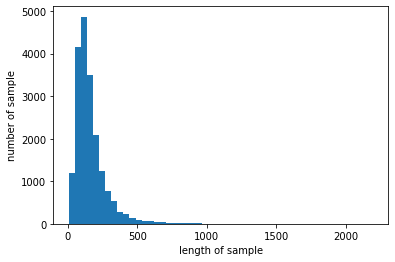

In [18]:
#제안 길이수 확인
print('제안의 최대 길이 :',max(len(review) for review in df_list))
print('제안의 평균 길이 :',sum(map(len, df_list))/len(df_list))
plt.hist([len(s) for s in df_list], bins=50)
plt.xlabel('length of sample')
plt.ylabel('number of sample')
plt.show()

In [19]:
#전체 제안 중 길이 비율 확인
def below_threshold_len(max_length, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_length):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_length, (count / len(nested_list))*100))

max_length = 256
below_threshold_len(max_length, df_list)

전체 샘플 중 길이가 256 이하인 샘플의 비율: 86.39967054463091


In [20]:
#train/test를 위핼 리스트형식으로 변환
data_list = []
for q, label in zip(df_list, df['제안구분'])  :
    data = []
    data.append(q)
    data.append(str(label))

    data_list.append(data)
print(data_list[0])
print(data_list[6000])
print(data_list[12000])
print(data_list[18000])
print(data_list[-1])

['국민 통장 입출금거래내역 표시건 표시 수정요청건 매월 일에 가계부 기능으로 금액이 표시되는데 얼핏 보기엔 거래내역이 연속된 것처럼 보여서 고객이 입금 출금의 착오가 있다고 확인해 달라고 하는 사례가 발생 되고 있습니다 가계부 내용을 표시하기전에 전자금융 이만영 농협 가계부기능 전월 총 입금건수 건 입급금액 원 전월 총 출금건수 건 출금금액 원 전월 총 수수료면제건수 건 면제금액 원 날짜 대신에 가계부기능 이라고 넣어 주는 표기 방법과 한줄의 선을 그어서 입 출금과 내용구분이 필요할 것 같습니다 고객님이 입출금 내용에 대한 혼동으로 창구에 와서 입 출금 내역이 잘못 되었다고 하며 재확인을 해달라는 불필요한 시간을 없앨 수 있고 입 출금 잘못된게 아닌가 하는 걱정과 혼동을 줄일 수 있어 거래내역에 대한 신뢰도를 높일 수 있음', '14']
['카드 분실 거래 후 바로 재발행 할 수 있도록 전산 개선 재발행에 대한 업무 시간 감소 도난분실 카드에 대한 사고율 감소', '138']
['에서 우클릭 거래내역 조회 시 계좌번호 연동이 안되는 문제 우클릭하여 거래내역 조회시 처음부터 자동으로 화면으로 연동되게 하거나 화면으로 자동진입시 열리는 알림팝업을 통해 으로 들어가도 계좌번호가 연동되도록 개선해주시면 감사하겠습니다', '3']
['출납시재분리 시재마감 편의', '18']
['당첨된 청약통장 청약불가표시 고객이 통장정리 및 입금시 청약불가안내 팝업 및 통장에 인자하여 청약불가통장임을 인지할수 있도록 개선 요청함 고객만족 및 불필요한 민원방지', '23']


In [21]:
#train & test 데이터로 나누기(8:2로 진행하였으나, 테스트 데이터가 많지 않아 9:1로 수정)
from sklearn.model_selection import train_test_split
                                                         
dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, random_state=0)

In [22]:
print(len(dataset_train))
print(len(dataset_test))

17483
1943


**4. KoBERT 입력 데이터로 만들기**


데이터를 train data와 test data로 나누었다면 각 데이터가 KoBERT 모델의 입력으로 들어갈 수 있는 형태가 되도록 토큰화, 정수 인코딩, 패딩 등을 해주어야 한다. 예시 코드에 입력데이터의 형태가 되도록 해주는 클래스가 있어서 동일하게 코드를 작성해주었다.

In [23]:
#Bert 모델 적용(transform/sentence/label)
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

코드를 보면, 위에서 import 해주었던 BERTSentenceTransform 이라는 모듈을 사용한다. 그리고이 모듈을 통해 토큰화와 패딩이 이루어지는 것 같다. 우선 이 클래스를 정의해준다.

그리고나서 하이퍼 파라미터들을 조정해준다. Batch size는 64, epochs는 5, learning rate는 5e-5로 설정해주었다. 사실 파라미터의 값은 정답이 없고 가장 좋은 성능을 내는 값을 찾아가는 것이 좋다. 하지만 난 그냥 예시 코드에 있는 값들을 동일하게 설정해주었다.

In [24]:
# Setting parameters
max_len = 256
batch_size = 16
warmup_ratio = 0.1
num_epochs = 20
max_grad_norm = 1
log_interval = 200
learning_rate = 1e-5

그리고 이제 버트토크나이저와 위에서 정의한 클래스를 적용해 토큰화와 패딩을 해준다.

In [25]:
#토큰화
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()

tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

data_train = BERTDataset(dataset_train, 0, 1, tok, max_len, True, False)
data_test = BERTDataset(dataset_test, 0, 1, tok, max_len, True, False)

/content/.cache/kobert_v1.zip[██████████████████████████████████████████████████]
/content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece[██████████████████████████████████████████████████]
using cached model. /content/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


토큰화와 패딩이 잘 이루어져있는지 확인하기 위해 data_train[0]을 실행해보면 다음과 같은 값들이 출력될 것이다.

In [26]:
data_train[0]

(array([   2, 1832, 7402, 5495, 6364, 6985, 6999, 7431, 7848, 6999,  994,
        5778, 3647, 3084, 5760, 6016, 7088, 3093, 6738, 6629, 7141, 5861,
        1469, 6213, 7402, 7088,  517, 6538, 7078, 2340, 7848, 6586, 4353,
        7941, 6198, 6903, 5130, 6323, 7668, 4689, 6132, 7836, 6629, 7141,
        5400, 1943, 7282, 2872, 7028, 7784, 3264, 7418,  737, 7784, 1943,
        7276, 6745,  793, 7782, 5409,    3,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1, 

출력값들을 보면 3개의 array가 출력되는데, 첫 번째는 패딩된 시퀀스, 두 번째는 길이와 타입에 대한 내용, 세 번재는 어텐션 마스크 시퀀스이다. 어텐션 마스크는 지난 BERT 프로젝트 글에서도 설명했었는데, BERT에 데이터가 입력되었을 때 어텐션 함수가 적용되어 연산이 된다. 이때 1로 패딩된 값들은 연산할 필요가 없기 때문에 연산을 하지 않아도 된다고 알려주는 데이터가 있어야 하는데 그게 바로 어텐션 마스크 시퀀스인 것이다. 이렇게 BERT나 KoBERT에는 어텐션 마스크 데이터도 함께 입력되어야 한다

In [27]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


5. KoBERT 학습모델 만들기

학습시킬 KoBERT 모델을 만들어야 하는데, 아래 코드에서 다중분류할 클래스 수 만큼 num_classes 변수를 수정해주어야 한다. 이번 프로젝트에서는 186가지의 class를 분류하기 때문에 186로 입력해주었다.

In [28]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=154,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        print(self.classifier)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [29]:
#BERT 모델 불러오기
#GPU 사용
model = BERTClassifier(bertmodel, dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    
train_dataloader

Linear(in_features=768, out_features=154, bias=True)


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [30]:
import torch
import gc
torch.cuda.empty_cache()
gc.collect()

0

**6. KoBERT 모델 학습시키기**

학습 데이터셋과 학습 모델 준비가 다 끝났다면 이제 아래 코드 실행을 통해 KoBERT 모델을 학습시켜준다.

In [31]:
from tqdm.notebook import tqdm
import torch
import gc

# 5개를 추출하여 1개를 뽑았을때 정확도를 측정할 수 있는 코드
def calc_accuracy_top_5(X, Y):
  X = X.tolist()
  Y = Y.tolist()

  top_5_indices = []
  indices = []

  #상위 5개 찾기
  for val in X:
    for i in range(5):
      indices.append(val.index(max(val)))
      val.remove(max(val))
    top_5_indices.append(indices)

  #Accuracy 계산
  correct = 0
  for pred, label in zip(top_5_indices, Y):
    if label in pred:
      correct += 1
  
  top_5_acc = correct/len(Y)
  return top_5_acc

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy_top_5(out, label)      
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

  0%|          | 0/1093 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch 1 batch id 1 loss 5.077123165130615 train acc 0.0
epoch 1 batch id 201 loss 5.031529903411865 train acc 0.009639303482587064
epoch 1 batch id 401 loss 5.012192249298096 train acc 0.011221945137157107
epoch 1 batch id 601 loss 5.016826629638672 train acc 0.025270382695507486
epoch 1 batch id 801 loss 4.809556484222412 train acc 0.035580524344569285
epoch 1 batch id 1001 loss 4.924027919769287 train acc 0.04202047952047952
epoch 1 train acc 0.043058096980786824


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 1 test acc 0.22182377049180327


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 4.521883964538574 train acc 0.1875
epoch 2 batch id 201 loss 4.381480693817139 train acc 0.07431592039800995
epoch 2 batch id 401 loss 4.6310529708862305 train acc 0.07341022443890274
epoch 2 batch id 601 loss 4.75101900100708 train acc 0.09245008319467554
epoch 2 batch id 801 loss 4.267906665802002 train acc 0.11579275905118602
epoch 2 batch id 1001 loss 4.388130187988281 train acc 0.13505244755244755
epoch 2 train acc 0.14317869915994344


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 2 test acc 0.48104508196721313


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 3.8896071910858154 train acc 0.1875
epoch 3 batch id 201 loss 3.653170108795166 train acc 0.2506218905472637
epoch 3 batch id 401 loss 3.8885111808776855 train acc 0.2559226932668329
epoch 3 batch id 601 loss 4.016326904296875 train acc 0.2672628951747088
epoch 3 batch id 801 loss 3.520453453063965 train acc 0.28058676654182274
epoch 3 batch id 1001 loss 3.685969591140747 train acc 0.29033466533466534
epoch 3 train acc 0.29579243949097567


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 3 test acc 0.6283665105386418


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 3.371321678161621 train acc 0.3125
epoch 4 batch id 201 loss 2.9095511436462402 train acc 0.3473258706467662
epoch 4 batch id 401 loss 3.0895261764526367 train acc 0.35037406483790523
epoch 4 batch id 601 loss 3.5920913219451904 train acc 0.3512895174708819
epoch 4 batch id 801 loss 3.1066884994506836 train acc 0.36142322097378277
epoch 4 batch id 1001 loss 3.20988392829895 train acc 0.36644605394605395
epoch 4 train acc 0.3705605921982866


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 4 test acc 0.6621779859484778


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 2.992449998855591 train acc 0.25
epoch 5 batch id 201 loss 2.348228693008423 train acc 0.402363184079602
epoch 5 batch id 401 loss 2.836336851119995 train acc 0.41209476309226933
epoch 5 batch id 601 loss 3.243072986602783 train acc 0.4193011647254576
epoch 5 batch id 801 loss 2.7879414558410645 train acc 0.4282147315855181
epoch 5 batch id 1001 loss 2.994469165802002 train acc 0.4344405594405594
epoch 5 train acc 0.4382017799218165


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 5 test acc 0.6925497658079626


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 2.7036399841308594 train acc 0.375
epoch 6 batch id 201 loss 2.0848093032836914 train acc 0.464863184079602
epoch 6 batch id 401 loss 2.4716968536376953 train acc 0.4722568578553616
epoch 6 batch id 601 loss 2.778444528579712 train acc 0.4794093178036606
epoch 6 batch id 801 loss 2.2944416999816895 train acc 0.48774968789013734
epoch 6 batch id 1001 loss 2.5852034091949463 train acc 0.4911963036963037
epoch 6 train acc 0.49535265740663725


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 6 test acc 0.7307523419203746


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 2.330331802368164 train acc 0.375
epoch 7 batch id 201 loss 1.8049689531326294 train acc 0.5146144278606966
epoch 7 batch id 401 loss 2.3011538982391357 train acc 0.524002493765586
epoch 7 batch id 601 loss 2.7394471168518066 train acc 0.5272462562396006
epoch 7 batch id 801 loss 2.1175355911254883 train acc 0.5327715355805244
epoch 7 batch id 1001 loss 2.370161533355713 train acc 0.5370879120879121
epoch 7 train acc 0.5404381186060051


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 7 test acc 0.7546838407494145


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 2.009913206100464 train acc 0.5
epoch 8 batch id 201 loss 1.700848937034607 train acc 0.5497512437810945
epoch 8 batch id 401 loss 2.075016975402832 train acc 0.5567331670822943
epoch 8 batch id 601 loss 2.4958858489990234 train acc 0.5597961730449251
epoch 8 batch id 801 loss 1.7674871683120728 train acc 0.5673377028714107
epoch 8 batch id 1001 loss 2.0569815635681152 train acc 0.5721778221778222
epoch 8 train acc 0.5762081011394826


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 8 test acc 0.7570989461358314


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 1.7672581672668457 train acc 0.5
epoch 9 batch id 201 loss 1.5155221223831177 train acc 0.5942164179104478
epoch 9 batch id 401 loss 2.1119165420532227 train acc 0.5986596009975063
epoch 9 batch id 601 loss 2.532388925552368 train acc 0.600769550748752
epoch 9 batch id 801 loss 1.7235021591186523 train acc 0.6058832709113608
epoch 9 batch id 1001 loss 1.8513976335525513 train acc 0.6093906093906094
epoch 9 train acc 0.6127162521833153


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 9 test acc 0.7668325526932085


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 1.48673415184021 train acc 0.6875
epoch 10 batch id 201 loss 1.3355849981307983 train acc 0.6284203980099502
epoch 10 batch id 401 loss 1.974718451499939 train acc 0.6315461346633416
epoch 10 batch id 601 loss 2.4112062454223633 train acc 0.6311356073211315
epoch 10 batch id 801 loss 1.4324314594268799 train acc 0.6356117353308365
epoch 10 batch id 1001 loss 1.7417271137237549 train acc 0.6366758241758241
epoch 10 train acc 0.639763370207103


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 10 test acc 0.7741510538641686


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 11 batch id 1 loss 1.4936891794204712 train acc 0.6875
epoch 11 batch id 201 loss 1.349822998046875 train acc 0.6567164179104478
epoch 11 batch id 401 loss 1.7130075693130493 train acc 0.6578865336658354
epoch 11 batch id 601 loss 2.029384136199951 train acc 0.6591098169717138
epoch 11 batch id 801 loss 1.3722584247589111 train acc 0.6604244694132334
epoch 11 batch id 1001 loss 1.628597378730774 train acc 0.6623376623376623
epoch 11 train acc 0.6654953006737088


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 11 test acc 0.7857874707259953


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 12 batch id 1 loss 1.2725458145141602 train acc 0.6875
epoch 12 batch id 201 loss 1.0929160118103027 train acc 0.6819029850746269
epoch 12 batch id 401 loss 1.7122666835784912 train acc 0.6818890274314214
epoch 12 batch id 601 loss 2.0653085708618164 train acc 0.6831322795341098
epoch 12 batch id 801 loss 1.2307783365249634 train acc 0.6840667915106118
epoch 12 batch id 1001 loss 1.635051965713501 train acc 0.6875
epoch 12 train acc 0.6905982283955752


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 12 test acc 0.7878366510538641


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 13 batch id 1 loss 1.3203511238098145 train acc 0.625
epoch 13 batch id 201 loss 1.0543090105056763 train acc 0.7021144278606966
epoch 13 batch id 401 loss 1.7098197937011719 train acc 0.7032418952618454
epoch 13 batch id 601 loss 1.994914174079895 train acc 0.6991472545757071
epoch 13 batch id 801 loss 1.2251431941986084 train acc 0.7024812734082397
epoch 13 batch id 1001 loss 1.5051190853118896 train acc 0.7024225774225774
epoch 13 train acc 0.7048053730350162


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 13 test acc 0.7862997658079626


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 14 batch id 1 loss 1.198951005935669 train acc 0.75
epoch 14 batch id 201 loss 1.104629397392273 train acc 0.7276119402985075
epoch 14 batch id 401 loss 1.3764740228652954 train acc 0.7205423940149626
epoch 14 batch id 601 loss 2.0164873600006104 train acc 0.716514143094842
epoch 14 batch id 801 loss 1.0792663097381592 train acc 0.720583645443196
epoch 14 batch id 1001 loss 1.3451473712921143 train acc 0.721028971028971
epoch 14 train acc 0.7236442651584464


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 14 test acc 0.7822014051522248


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 15 batch id 1 loss 1.067177653312683 train acc 0.75
epoch 15 batch id 201 loss 1.007976770401001 train acc 0.7310323383084577
epoch 15 batch id 401 loss 1.3505069017410278 train acc 0.7323877805486284
epoch 15 batch id 601 loss 1.859696626663208 train acc 0.7292013311148087
epoch 15 batch id 801 loss 1.0675742626190186 train acc 0.732599875156055
epoch 15 batch id 1001 loss 1.2994352579116821 train acc 0.7319555444555444
epoch 15 train acc 0.7347999667304334


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 15 test acc 0.7956674473067915


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 16 batch id 1 loss 0.8639472126960754 train acc 0.8125
epoch 16 batch id 201 loss 0.974503219127655 train acc 0.7394278606965174
epoch 16 batch id 401 loss 1.323787808418274 train acc 0.7400249376558603
epoch 16 batch id 601 loss 1.7905763387680054 train acc 0.7372088186356073
epoch 16 batch id 801 loss 0.9805386662483215 train acc 0.741729088639201
epoch 16 batch id 1001 loss 1.3068971633911133 train acc 0.7415084915084915
epoch 16 train acc 0.7436008067869917


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 16 test acc 0.7968384074941451


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 17 batch id 1 loss 0.9338271021842957 train acc 0.6875
epoch 17 batch id 201 loss 0.9230661988258362 train acc 0.7546641791044776
epoch 17 batch id 401 loss 1.5246140956878662 train acc 0.7531172069825436
epoch 17 batch id 601 loss 1.8744240999221802 train acc 0.7494800332778702
epoch 17 batch id 801 loss 0.9747586250305176 train acc 0.7507022471910112
epoch 17 batch id 1001 loss 1.112878680229187 train acc 0.751560939060939
epoch 17 train acc 0.7528954919737171


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 17 test acc 0.8075966042154566


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 18 batch id 1 loss 0.914812445640564 train acc 0.8125
epoch 18 batch id 201 loss 0.8159905672073364 train acc 0.7658582089552238
epoch 18 batch id 401 loss 1.2783896923065186 train acc 0.7651184538653366
epoch 18 batch id 601 loss 1.6309850215911865 train acc 0.7575915141430949
epoch 18 batch id 801 loss 1.0099035501480103 train acc 0.7574906367041199
epoch 18 batch id 1001 loss 1.0755274295806885 train acc 0.7546203796203796
epoch 18 train acc 0.7571529568327373


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 18 test acc 0.7973507025761124


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 19 batch id 1 loss 0.8336664438247681 train acc 0.8125
epoch 19 batch id 201 loss 0.8253951072692871 train acc 0.7568407960199005
epoch 19 batch id 401 loss 1.2561683654785156 train acc 0.7562344139650873
epoch 19 batch id 601 loss 1.7483375072479248 train acc 0.7539517470881864
epoch 19 batch id 801 loss 0.8825578689575195 train acc 0.7553058676654182
epoch 19 batch id 1001 loss 1.1398725509643555 train acc 0.755432067932068
epoch 19 train acc 0.7573556932545954


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 19 test acc 0.7999121779859484


  0%|          | 0/1093 [00:00<?, ?it/s]

epoch 20 batch id 1 loss 0.9080545902252197 train acc 0.8125
epoch 20 batch id 201 loss 0.9226778745651245 train acc 0.7699004975124378
epoch 20 batch id 401 loss 1.435239315032959 train acc 0.7616895261845387
epoch 20 batch id 601 loss 1.741044521331787 train acc 0.7559276206322796
epoch 20 batch id 801 loss 0.9966646432876587 train acc 0.7589731585518102
epoch 20 batch id 1001 loss 1.0119351148605347 train acc 0.7586163836163836
epoch 20 train acc 0.7603603509939283


  0%|          | 0/122 [00:00<?, ?it/s]

epoch 20 test acc 0.8188670960187353


In [32]:
PATH = '/content/drive/MyDrive/'

torch.save(model, PATH + 'model_recent.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict_recent.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all_recent.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능